In [1]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD
from keras.layers import Conv1D, Flatten, LSTM, Reshape, BatchNormalization, Activation, UpSampling1D, ZeroPadding1D, PReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataDir = "/content/drive/MyDrive/Mini Project- AG2RS1-6.0/New/Data/phy/"
mat = scipy.io.loadmat(dataDir + 'data_SanBernardino.mat')

In [6]:
ga=mat["input_tf"][:,2000:4000]
ba=mat["target_tf"][:,2000:4000,:]
ga=np.reshape(ga,[ga.shape[0],ga.shape[1],1])
ba=np.reshape(ba,[ba.shape[0],ba.shape[1],2])

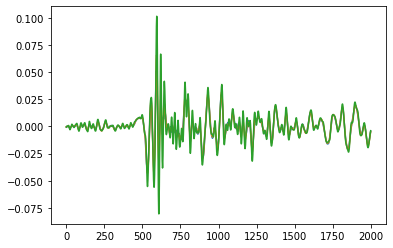

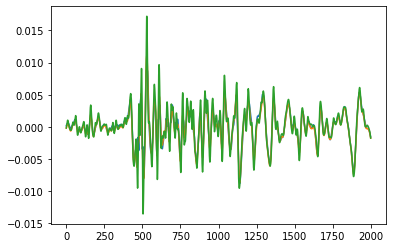

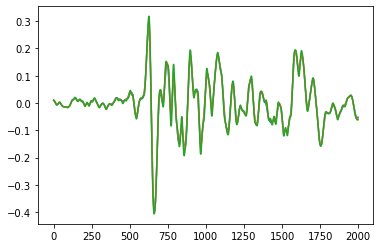

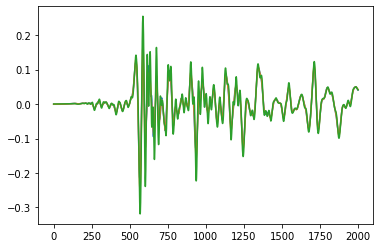

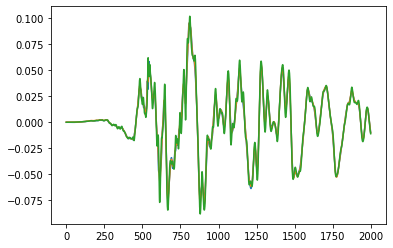

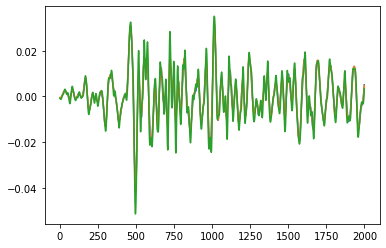

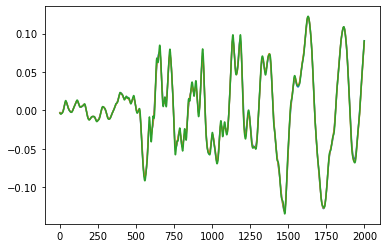

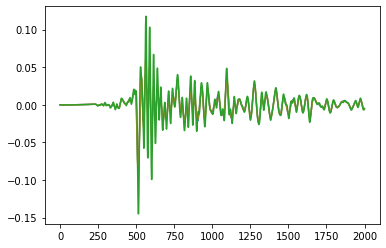

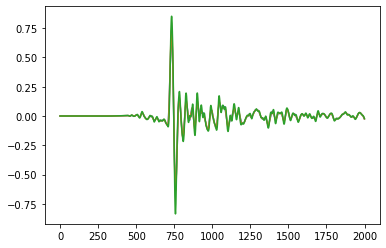

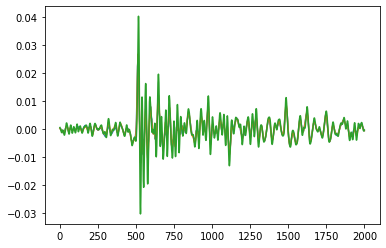

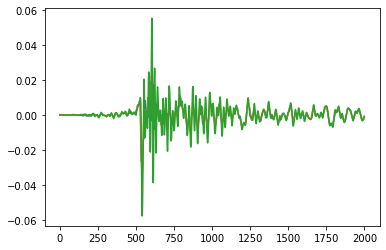

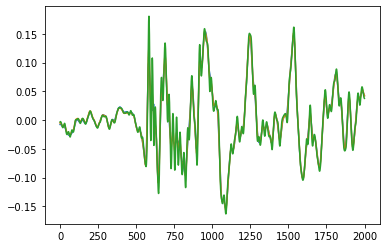

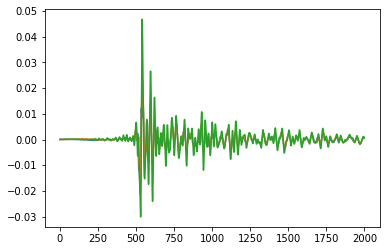

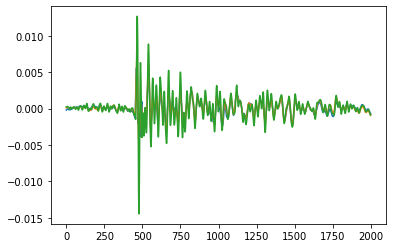

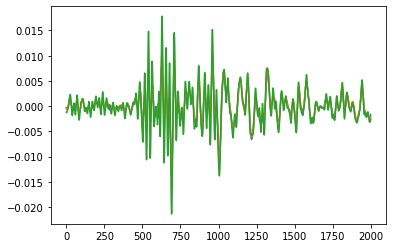

In [7]:
for i in range(len(ga)):
  plt.figure()
  plt.plot(ga[i])
  plt.plot(ba[i])


In [8]:
class DeepPhyLSTM:
    # Initialize the class
    def __init__(self, eta_tt, ag, Phi_t):

        # data
        self.eta_tt = eta_tt
        self.ag = ag
        self.Phi_t = Phi_t

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # placeholders for data
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.eta_tt_tf = tf.placeholder(tf.float32, shape=[None, None, self.eta_tt.shape[2]])
        self.ag_tf = tf.placeholder(tf.float32, shape=[None, None, 1])

        # physics informed neural networks
        self.eta_pred, self.eta_t_pred, self.eta_tt_pred, = self.net_structure(self.ag_tf)

        # loss
        # for measurements
        self.loss = tf.reduce_mean(tf.square(self.eta_tt_tf - self.eta_tt_pred)) + tf.reduce_mean(tf.square(self.eta_pred[:,:,0:10]))

        # optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 20000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def CNN_model(self, X):
        model = Sequential()
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True, input_shape=(None, 1)))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Conv1D(64, 50, strides=1, padding='same', use_bias=True))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('relu'))
        model.add(Dense(self.eta_tt.shape[2]))
        y = model(X)
        return y

    def net_structure(self, ag):
        eta = self.CNN_model(ag)

        Phi_ut = np.reshape(self.Phi_t, [1, self.eta_tt.shape[1], self.eta_tt.shape[1]])
        Phi_ut = np.repeat(Phi_ut, self.eta_tt.shape[0], axis=0)
        eta_t = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta)
        eta_tt = tf.matmul(tf.cast(Phi_ut, dtype=tf.float32), eta_t)

        return eta, eta_t, eta_tt
    
    def train(self, num_epochs, batch_size, learning_rate, bfgs):

        Loss = []

        for epoch in range(num_epochs):
            
            N = self.eta_tt.shape[0]

            start_time = time.time()
            for it in range(0, N, batch_size):
                tf_dict = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}
                self.sess.run(self.train_op, tf_dict)
                
                # Print
                if it % (10*batch_size) == 0:
                    elapsed = time.time() - start_time
                    loss_value, learning_rate_value = self.sess.run([self.loss, self.learning_rate], tf_dict)
                    print('Epoch: %d, It: %d, Loss: %.3e, Time: %.2f, Learning Rate: %.3e'
                          %(epoch, it/batch_size, loss_value, elapsed, learning_rate_value))
                    start_time = time.time()

            Loss.append(self.sess.run(self.loss, tf_dict))

        if bfgs == 1:
            tf_dict_all = {self.eta_tt_tf: self.eta_tt, self.ag_tf: self.ag, self.learning_rate: learning_rate}

            self.optimizer.minimize(self.sess,
                                    feed_dict=tf_dict_all,
                                    fetches=[self.loss],
                                    loss_callback=self.callback)

            Loss.append(self.sess.run(self.loss, tf_dict))

        return Loss

    def callback(self, loss):
        print('Loss:', loss)

    def predict(self, ag_star):
        
        tf_dict = {self.ag_tf: ag_star}

        eta_star = self.sess.run(self.eta_pred, tf_dict)
        eta_t_star = self.sess.run(self.eta_t_pred, tf_dict)
        eta_tt_star = self.sess.run(self.eta_tt_pred, tf_dict)

        return eta_star, eta_t_star, eta_tt_star

In [10]:
dt = 0.02
# finite difference
n = ba.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n - 3, ])])
temp1 = np.concatenate([-1 / 2 * np.identity(n - 2), np.zeros([n - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n - 2, 2]), 1 / 2 * np.identity(n - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n - 3, ]), np.array([1 / 2, -2, 3 / 2])])
Phi_t = 1 / dt * np.concatenate(
            [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Epoch: 0, It: 0, Loss: 2.843e-03, Time: 17.05, Learning Rate: 1.000e-03
Epoch: 1, It: 0, Loss: 2.313e-03, Time: 0.07, Learning Rate: 1.000e-03
Epoch: 2, It: 0, Loss: 1.835e-03, Time: 0.07, Learning Rate: 1.000e-03
Epoch: 3, It: 0, Loss: 1.744e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 4, It: 0, Loss: 2.044e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 5, It: 0, Loss: 1.382e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 6, It: 0, Loss: 1.858e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 7, It: 0, Loss: 1.477e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 8, It: 0, Loss: 1.294e-03, Time: 0.04, Learning Rate: 1.000e-03
Epoch: 9, It: 0, Loss: 1.182e-03, Time: 0.04, Learning Rate: 1.000e-

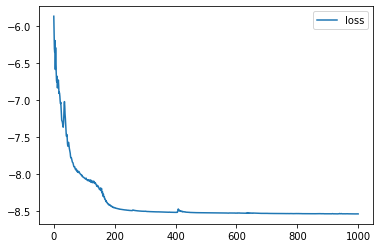

In [12]:
with tf.device('/device:GPU:1'):
    # with tf.device('/cpu:0'):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    session = tf.Session(config=config)
    # tf.Session(config=tf.ConfigProto(log_device_placement=True))

    # Training
    model = DeepPhyLSTM(ba, ga, Phi_t)

    Loss = model.train(num_epochs=1000, batch_size=15, learning_rate=1e-3, bfgs=1)
 
    train_loss = Loss

    plt.figure()
    plt.plot(np.log(train_loss), label='loss')
    # plt.plot(np.log(test_loss), label='loss_val')
    plt.legend()

In [13]:
eta, eta_t, eta_tt = model.predict(ga)


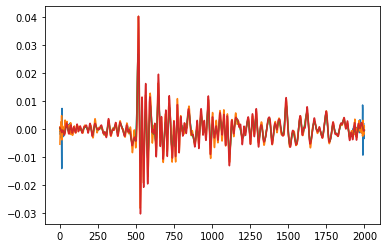

In [26]:
plt.plot(eta_tt[9])
plt.plot(ba[9])

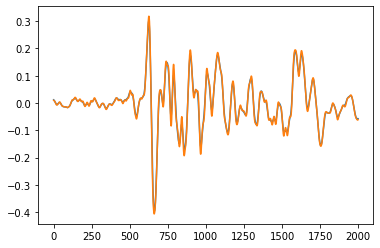

In [21]:
plt.plot(ba[2])

In [29]:
gap=mat["input_pred_tf"][:,2000:4000]
bap=mat["target_pred_tf"][:,2000:4000,:]
gap=np.reshape(gap,[gap.shape[0],gap.shape[1],1])
bap=np.reshape(bap,[bap.shape[0],bap.shape[1],2])

In [30]:
 p=np.concatenate([gap,gap,gap[0:3]], axis=0)

In [31]:
a,b,c=model.predict(p)

In [32]:
a.shape

(15, 2000, 2)

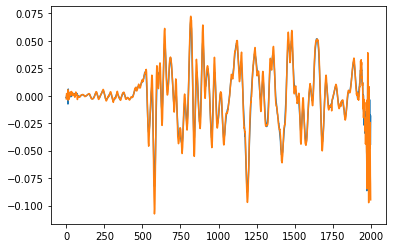

In [35]:
plt.plot(c[1])


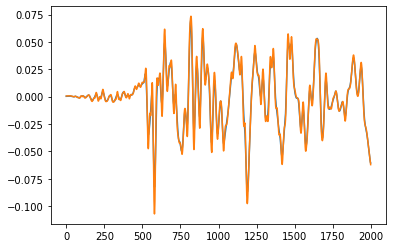

In [36]:
plt.plot(bap[1])